Rotation (Video should be in 1080x1920) resolution

In [189]:
import cv2


# Path to input and output video
input_path = r"C:\Users\akhileshsing2024\Desktop\Master_gait_videos\20250528_113958.mp4"
output_path = r"C:\Users\akhileshsing2024\Desktop\Master_gait_videos\gaitlabtest2.mp4"

# Open video
cap = cv2.VideoCapture(input_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # swapped due to rotation
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define output video
# fourcc = cv2.VideoWriter_fourcc(*'movv')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Rotate frame 90 degrees clockwise
    #rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #Rotate from 180 degrees 
    #rotated_frame = cv2.rotate(frame, cv2.ROTATE_180)

    # Write frame
    out.write(rotated_frame)

# Release
cap.release()
out.release()
print("Saved rotated video as:", output_path)


Saved rotated video as: C:\Users\akhileshsing2024\Desktop\Master_gait_videos\gaitlabtest2.mp4


Run Alphapose

<!-- Joints -->
0. Nose
1. Left Eye
2. Right Eye
3. Left Ear
4. Right Ear
5. Left Shoulder
6. Right Shoulder
7. Left Elbow
8. Right Elbow
9. Left Wrist
10. Right Wrist
11. Left Hip
12. Right Hip
13. Left Knee
14. Right Knee
15. Left Ankle
16. Right Ankle

In [ ]:
# set PYTHONPATH=%PYTHONPATH%;C:\Users\akhileshsing2024\AlphaPose
# python scripts\demo_inference.py --cfg configs\coco\resnet\256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models\fast_res50_256x192.pth --video "C:\Users\akhileshsing2024\Downloads\GaitAnalysisProject\openpose\openpose\examples\media\120FPS_short_rotated.mov" --outdir output\ --save_video --pose_track

Plot Alphapose

In [199]:
import json
import pandas as pd

# Path to your single AlphaPose JSON file
json_file = r"C:\Users\akhileshsing2024\AlphaPose\output\gait lab\alphapose-results.json"

# Output Excel file path
output_excel = r"C:\Users\akhileshsing2024\AlphaPose\output\gait lab\alphapose-results_gaitlab.xlsx"

keypoint_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

data = []

with open(json_file, 'r') as f:
    json_data = json.load(f)

# json_data is a list of people dictionaries
people = json_data

for person_idx, person in enumerate(people):
    keypoints = person.get("keypoints", [])
    if not keypoints:
        continue

    for i in range(0, len(keypoints), 3):
        kp_id = i // 3
        x = keypoints[i]
        y = keypoints[i+1]
        confidence = keypoints[i+2]
        kp_name = keypoint_names[kp_id] if kp_id < len(keypoint_names) else f"Keypoint_{kp_id}"
        data.append({
            "Frame": person_idx + 1,
            "Keypoint": kp_name,
            "X": x,
            "Y": y,
            "Confidence": confidence
        })

df = pd.DataFrame(data)
df.to_excel(output_excel, index=False, engine="openpyxl")

print(f"Excel file saved to: {output_excel}")

Excel file saved to: C:\Users\akhileshsing2024\AlphaPose\output\gait lab\alphapose-results_gaitlab.xlsx


Run MotionBert

1. Hip
2. RHip
3. RKnee
4. RAnkle
5. LHip
6. LKnee
7. LAnkle
8. belly
9. Neck
10. Nose
11. Head
12. LShoulder
13. LElbow
14. LWrist
15. RShoulder
16. RElbow
17. RWrist

In [26]:
#python infer_wild.py --vid_path "C:\Users\akhileshsing2024\Downloads\GaitAnalysisProject\openpose\openpose\examples\media\120fps_rotated.mov" --json_path "C:\Users\akhileshsing2024\AlphaPose\output\alphapose-results.json" --out_path "C:\Users\akhileshsing2024\AlphaPose\results" 

Plot the 2d coordinates

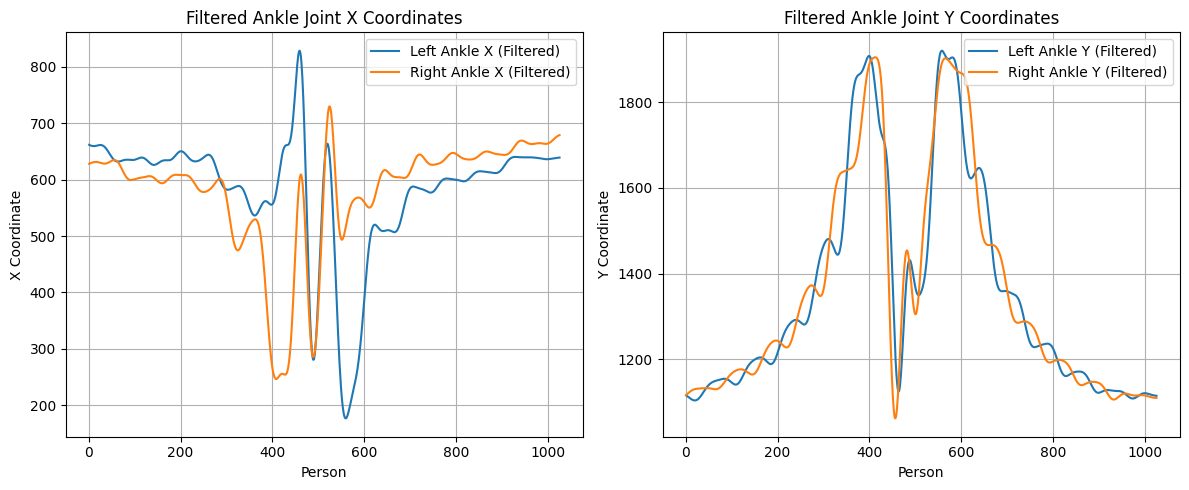

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file (update the path accordingly)
file_path = r"C:\Users\akhileshsing2024\AlphaPose\output\gait lab\alphapose-results_gaitlab.xlsx"
df = pd.read_excel(file_path)

# Filter data for the ankle joints only
ankle_df = df[df['Keypoint'].isin(['Left Ankle', 'Right Ankle'])]

# Pivot the data to have columns for Left Ankle X, Left Ankle Y, Right Ankle X, Right Ankle Y per frame/person
pivot_x = ankle_df.pivot(index='Frame', columns='Keypoint', values='X')
pivot_y = ankle_df.pivot(index='Frame', columns='Keypoint', values='Y')

# Butterworth low-pass filter design
def butter_lowpass_filter(data, cutoff=1.5, fs=60.0, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the filter to each ankle coordinate series
pivot_x_filtered = pivot_x.copy()
pivot_y_filtered = pivot_y.copy()

for col in pivot_x.columns:
    pivot_x_filtered[col] = butter_lowpass_filter(pivot_x[col].values)

for col in pivot_y.columns:
    pivot_y_filtered[col] = butter_lowpass_filter(pivot_y[col].values)

# Plotting the filtered data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(pivot_x_filtered.index, pivot_x_filtered['Left Ankle'], label='Left Ankle X (Filtered)')
plt.plot(pivot_x_filtered.index, pivot_x_filtered['Right Ankle'], label='Right Ankle X (Filtered)')
#plt.plot(pivot_x.index, pivot_x['Left Ankle'], label='Left Ankle X (Filtered)')
#plt.plot(pivot_x.index, pivot_x['Right Ankle'], label='Right Ankle X (Filtered)')
plt.xlabel('Person')  # Or 'Frame' if appropriate
plt.ylabel('X Coordinate')
plt.title('Filtered Ankle Joint X Coordinates')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(pivot_y_filtered.index, pivot_y_filtered['Left Ankle'], label='Left Ankle Y (Filtered)')
plt.plot(pivot_y_filtered.index, pivot_y_filtered['Right Ankle'], label='Right Ankle Y (Filtered)')
#plt.plot(pivot_y.index, pivot_y['Left Ankle'], label='Left Ankle Y (Filtered)')
#plt.plot(pivot_y.index, pivot_y['Right Ankle'], label='Right Ankle Y (Filtered)')
plt.xlabel('Person')  # Or 'Frame' if appropriate
plt.ylabel('Y Coordinate')
plt.title('Filtered Ankle Joint Y Coordinates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Motionbert .npy to excel

In [201]:
import numpy as np
import pandas as pd

# Load the .npy file
npy_path = r"C:\Users\akhileshsing2024\AlphaPose\results\X3D.npy"
# npy_path = r"C:\Users\akhileshsing2024\AlphaPose\results\X3D_non_normalized.npy"
data = np.load(npy_path)  # Shape: [frames, 17, 3] for keypoints



frames, joints, dims = data.shape
columns = []

# Generate column names like Joint0_X, Joint0_Y, Joint0_C, ...
for j in range(joints):
    columns.extend([f"Joint{j}_X", f"Joint{j}_Y", f"Joint{j}_z"])

# Flatten each frame into a row
flattened_data = data.reshape(frames, joints * dims)

# Convert to DataFrame
df = pd.DataFrame(flattened_data, columns=columns)

# Save to Excel
excel_path = r"C:\Users\akhileshsing2024\AlphaPose\results\alphapose_Motionbert__gait_lab_1_3d_output_keypoints.xlsx"
df.to_excel(excel_path, index=False)
print(f"Excel file saved to: {excel_path}")


Excel file saved to: C:\Users\akhileshsing2024\AlphaPose\results\alphapose_Motionbert__gait_lab_1_3d_output_keypoints.xlsx


In [ ]:
#Remove the data undetected
#Ex frames (429-539) / (415-439)

Plotting Normalised coordinates

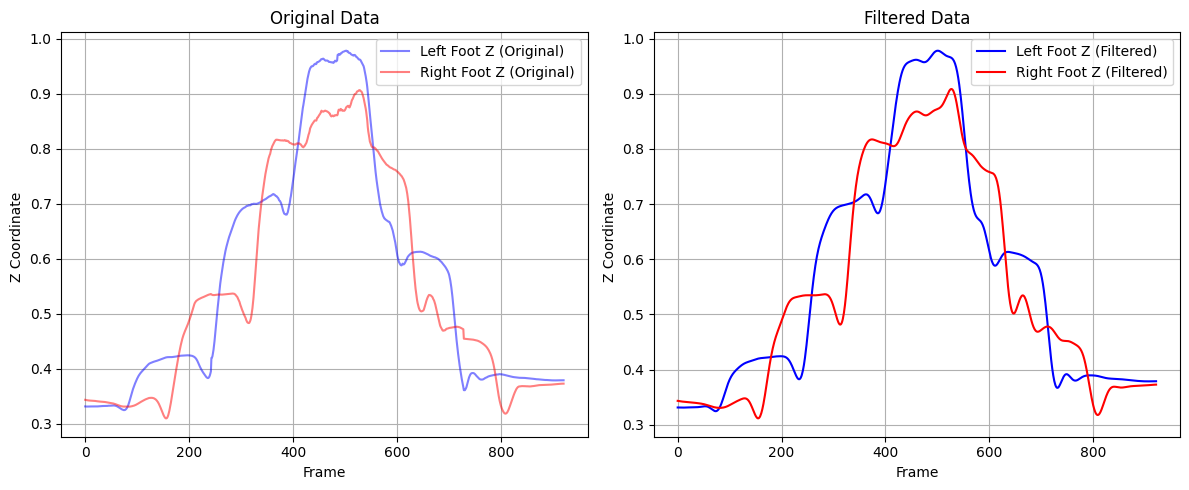

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_short\alphapose_Motionbert_3d_output_keypoints_12fps_short_normalised.xlsx"
df = pd.read_excel(file_path)

# Extract Y-axis data for left and right foot
lfoot_y = df['Joint3_Y']
rfoot_y = df['Joint6_Y']

# Define Butterworth low-pass filter parameters
cutoff = 2  # Cutoff frequency in Hz
order = 5  # Filter order
fs = 60     # Sampling rate in Hz

# Design Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter to data
def apply_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Filter the data
lfoot_y_filtered = apply_lowpass_filter(lfoot_y, cutoff, fs, order)
rfoot_y_filtered = apply_lowpass_filter(rfoot_y, cutoff, fs, order)

# Create subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Original data
plt.subplot(1, 2, 1)
plt.plot(lfoot_y, label='Left Foot Z (Original)', color='blue', alpha=0.5)
plt.plot(rfoot_y, label='Right Foot Z (Original)', color='red', alpha=0.5)
plt.title('Original Data')
plt.xlabel('Frame')
plt.ylabel('Z Coordinate ')
plt.legend()
plt.grid(True)

# Subplot 2: Filtered data
plt.subplot(1, 2, 2)
plt.plot(lfoot_y_filtered, label='Left Foot Z (Filtered)', color='blue')
plt.plot(rfoot_y_filtered, label='Right Foot Z (Filtered)', color='red')
plt.title('Filtered Data')
plt.xlabel('Frame')
plt.ylabel('Z Coordinate ')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Convert Normalised to Meters

In [ ]:
import numpy as np
import pandas as pd

# Conversion parameters
height = 1.7  # Meters
z_diff = abs(0.193932 - (-0.062291108071804))  # Head to hip z-difference /head to mid point of ankle{10-()}
#z_diff = abs(0.2072195 - (-0.0420548021793365)) 
#z_diff=abs(0.14918534-(-0.022014))
scaling_factor = height / z_diff  # Meters per unit
# y_min, y_max = -0.0519746467471123, 0.953994513
y_min,y_max=-0.00259,0.92198
#y_min,y_max=0.309594,0.978396
#y_min,y_max=0.16315, 0.952746
# depth_min, depth_max =  6.4, 0   # Meters (adjusted for correct motion)
depth_min,depth_max= 7.936 ,2.519
y_range = y_max - y_min
depth_range = depth_max - depth_min

# Joint names
# joint_names = [
#     "Hip", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle",
#     "belly", "Neck", "Nose", "Head", "LShoulder", "LElbow",
#     "LWrist", "RShoulder", "RElbow", "RWrist"
# ]
joint_names = [
    "Hip", "RHip", "RKnee", "RFoot", "LHip", "LKnee", "LFoot",
    "Spine", "Thorax", "Neck", "Head", "LShoulder", "LElbow",
    "LWrist", "RShoulder", "RElbow", "RWrist"
]
# Read the Excel file
input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_long\alphapose_Motionbert_120fps_3d_output_keypoints.xlsx"
df = pd.read_excel(input_file, sheet_name="Sheet1")
print(f"Number of rows in input DataFrame: {len(df)}")
# Initialize output DataFrame
output_columns = []
for joint in joint_names:
    output_columns.extend([f"{joint}_X_m", f"{joint}_Y_m", f"{joint}_Z_m"])
output_df = pd.DataFrame(index=df.index, columns=output_columns)

# Convert coordinates for each frame
for idx in df.index:
    for joint_idx, joint in enumerate(joint_names):
        x_n = df.at[idx, f"Joint{joint_idx}_X"]
        y_n = df.at[idx, f"Joint{joint_idx}_Y"]
        z_n = df.at[idx, f"Joint{joint_idx}_z"]
        
        # Handle potential invalid values
        if any(pd.isna(val) for val in [x_n, y_n, z_n]):
            x_real = y_real = z_real = float('nan')
        else:
            x_real = x_n * scaling_factor
            y_real = depth_min + ((y_n - y_min) / y_range) * depth_range
            z_real = z_n * scaling_factor
        
        # Store in output DataFrame
        output_df.at[idx, f"{joint}_X_m"] = round(x_real, 3)
        output_df.at[idx, f"{joint}_Y_m"] = round(y_real, 3)
        output_df.at[idx, f"{joint}_Z_m"] = round(z_real, 3)

# Save to a new Excel file
output_file = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_long\Alphapose_motionbert_converted_120fps_long_12_depth_0.xlsx"
output_df.to_excel(output_file, index=False)
print(f"Converted coordinates saved to {output_file}")

# Print first frame for verification
print("\nFirst frame converted coordinates (meters):")
for joint in joint_names:
    x = output_df.at[0, f"{joint}_X_m"]
    y = output_df.at[0, f"{joint}_Y_m"]
    z = output_df.at[0, f"{joint}_Z_m"]
    print(f"{joint}: ({x:.3f}, {y:.3f}, {z:.3f})")

Number of rows in input DataFrame: 1273
Converted coordinates saved to C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_long\Alphapose_motionbert_converted_120fps_long_12_depth_0.xlsx

First frame converted coordinates (meters):
Hip: (-1.230, 8.538, 0.000)
RHip: (-1.618, 8.534, -0.038)
RKnee: (-1.503, 7.258, 0.473)
RFoot: (-1.444, 6.173, 1.249)
LHip: (-0.857, 8.533, 0.084)
LKnee: (-0.946, 7.249, 0.538)
LFoot: (-1.021, 6.168, 1.324)
Spine: (-1.220, 9.391, -0.161)
Thorax: (-1.210, 10.255, -0.360)
Neck: (-1.232, 10.886, -0.627)
Head: (-1.224, 11.033, -0.413)
LShoulder: (-0.689, 10.218, -0.196)
LElbow: (-0.501, 9.362, 0.309)
LWrist: (-0.532, 8.595, 0.305)
RShoulder: (-1.744, 10.240, -0.324)
RElbow: (-1.897, 9.373, 0.140)
RWrist: (-1.870, 8.601, 0.201)


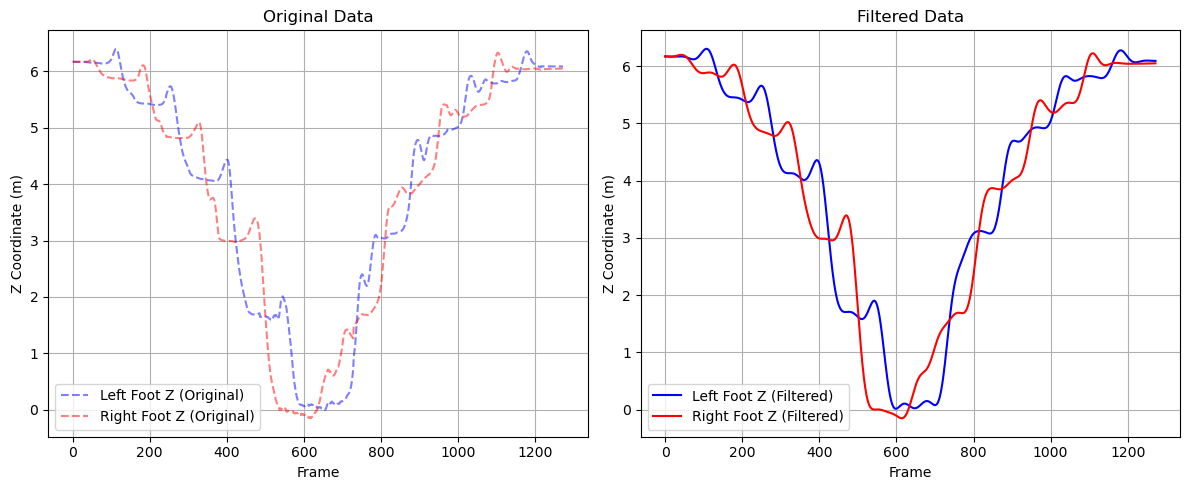

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_long\Alphapose_motionbert_converted_120fps_long_12_depth_0.xlsx"
df = pd.read_excel(file_path)

# Extract Y-axis data for left and right foot
lfoot_y = df['LFoot_Y_m']
rfoot_y = df['RFoot_Y_m']

# Define Butterworth low-pass filter parameters
cutoff = 2.2  # Cutoff frequency in Hz
order = 5   # Filter order
fs = 120     # Sampling rate in Hz

# Design Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter to data
def apply_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Filter the data
lfoot_y_filtered = apply_lowpass_filter(lfoot_y, cutoff, fs, order)
rfoot_y_filtered = apply_lowpass_filter(rfoot_y, cutoff, fs, order)

# Create subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Original data
plt.subplot(1, 2, 1)
plt.plot(lfoot_y, label='Left Foot Z (Original)', color='blue', alpha=0.5, linestyle='--')
plt.plot(rfoot_y, label='Right Foot Z (Original)', color='red', alpha=0.5, linestyle='--')
plt.title('Original Data')
plt.xlabel('Frame')
plt.ylabel('Z Coordinate (m)')
plt.legend()
plt.grid(True)

# Subplot 2: Filtered data
plt.subplot(1, 2, 2)
plt.plot(lfoot_y_filtered, label='Left Foot Z (Filtered)', color='blue')
plt.plot(rfoot_y_filtered, label='Right Foot Z (Filtered)', color='red')
plt.title('Filtered Data')
plt.xlabel('Frame')
plt.ylabel('Z Coordinate (m)')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np
import os

# Define input file and output folder
input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone_16_120fps_long\Alphapose_motionbert_converted_120fps_long_12_depth_0.xlsx"
output_folder = r"C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/120fps_kinect_body_joints_long_12_depth_0"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate output file path with same name as input but with .csv extension
output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(input_file))[0] + "_kinect.csv")

# Load the Excel file
df = pd.read_excel(input_file)

# Recording frame rate
frame_rate = 120

# Calculate timestamps
num_frames = len(df)
timestamps = np.linspace(0, num_frames / frame_rate, num_frames)

# Define joint names and map with Azure Kinect indices
joint_mapping = {
    "Hip": 0,        # Pelvis
    "RHip": 22,      # Hip Right
    "RKnee": 23,     # Knee Right
    "RFoot": 25,     # Foot Right
    "LHip": 18,      # Hip Left
    "LKnee": 19,     # Knee Left
    "LFoot": 21,     # Foot Left
    "Spine": 1,      # Spine Naval
    "Thorax": 2,     # Spine Chest
    "Neck": 3,       # Neck
    "Head": 26,      # Head
    "LShoulder": 5,  # Shoulder Left
    "LElbow": 6,     # Elbow Left
    "LWrist": 7,     # Wrist Left
    "RShoulder": 12, # Shoulder Right
    "RElbow": 13,    # Elbow Right
    "RWrist": 14     # Wrist Right
}
# joint_names = [
#     "Hip", "RHip", "RKnee", "RFoot", "LHip", "LKnee", "LFoot",
#     "Spine", "Thorax", "Neck", "Head", "LShoulder", "LElbow",
#     "LWrist", "RShoulder", "RElbow", "RWrist"
# ]
# Prepare output DataFrame
output_data = []

# Iterate through each frame
for frame_idx, row in df.iterrows():
    timestamp = timestamps[frame_idx]
    # Assume PersonID is in the DataFrame or default to 0 if not present
    person_id = row.get('PersonID', 0)
    
    # Iterate through each joint
    for joint, azure_idx in joint_mapping.items():
        # Convert coordinates from meters to millimeters
        pos_x = row[f'{joint}_X_m'] * 1000  # Convert to mm
        pos_y = row[f'{joint}_Y_m'] * 1000  # Convert to mm
        pos_z = row[f'{joint}_Z_m'] * 1000  # Convert to mm
        
        output_data.append({
            'Timestamp': timestamp,
            'BodyID': person_id,
            'Joint_': azure_idx,
            'Position_x_': pos_x,
            'Position_y_': pos_z,
            'Position_z_': pos_y
        })

# Create output DataFrame
output_df = pd.DataFrame(output_data)

# Save to CSV in the output folder
output_df.to_csv(output_file, index=False)

print(f"Converted data (in millimeters) saved to {output_file}")

Converted data (in millimeters) saved to C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/120fps_kinect_body_joints_long_12_depth_0\Alphapose_motionbert_converted_120fps_long_12_depth_0_kinect.csv


In [118]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import json

# Specify the file path to your JSON file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone-13 30fps\alphapose-results.json"  # Replace with your actual file path

# Read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Calculate height for each frame
frame_heights = []
for item in data:
    keypoints = item['keypoints']
    
    # Extract head (keypoint 0) and ankles (keypoints 15 and 16)
    head_y = keypoints[1]  # y-coordinate of keypoint 0 (nose/head)
    print(head_y)
    left_ankle_y = keypoints[46]  # y-coordinate of keypoint 15
    right_ankle_y = keypoints[49]  # y-coordinate of keypoint 16
    
    # Use the lower (larger y) ankle to estimate the bottom of the person
    ankle_y = max(left_ankle_y, right_ankle_y)
    
    # Calculate height as the vertical distance (in pixels)
    height_pixels = abs(ankle_y - head_y)
    
    frame_heights.append({
        'image_id': item['image_id'],
        'height_pixels': height_pixels
    })

# Create DataFrame
df = pd.DataFrame(frame_heights)

# Save to Excel
output_path = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone-13 30fps\person_heights.xlsx"  # Replace with your desired output path
df.to_excel(output_path, index=False)

print(f"Excel file with person heights saved to {output_path}")
print("\nHeight per frame (in pixels):")
print(df)

861.0355834960938
859.8856201171875
861.4954833984375
860.0501708984375
858.3896484375
858.0877685546875
858.582763671875
861.3972778320312
862.0928344726562
860.8898315429688
859.83984375
861.517333984375
861.0654296875
858.9895629882812
859.8497924804688
859.1536254882812
857.1193237304688
854.1913452148438
852.6365966796875
854.6306762695312
852.7967529296875
850.2529296875
847.7736206054688
849.3939208984375
845.5494995117188
845.3595581054688
846.8161010742188
847.289794921875
844.3612670898438
844.07275390625
843.2520141601562
844.2689819335938
843.837646484375
842.67578125
842.106689453125
842.86376953125
843.9425659179688
843.5403442382812
843.698974609375
843.2657470703125
841.6179809570312
842.254150390625
844.4674072265625
844.9683837890625
846.1046142578125
845.5565795898438
845.193359375
848.0174560546875
847.8680419921875
847.095947265625
844.7636108398438
846.2114868164062
843.62646484375
843.2879638671875
842.968017578125
838.8370971679688
840.3749389648438
835.64703369

#Pixel coordinates to Real World coordinates

In [ ]:
import pandas as pd

# Conversion parameters
height = 1.8  # meters
z_diff = abs(0.109544679522514 - (-0.0436989963054657))  # Head (Joint10) to Hip/knee (Joint0) from first frame
scaling_factor = height / z_diff  # 19.515 meters per unit
y_min, y_max = -0.0519746467471123, 0.953994513  # From first frame
depth_min, depth_max = 2.14, 6.42  # meters
y_range = y_max - y_min  # 0.610734641
depth_range = depth_max - depth_min  # 4.3

# Joint names
joint_names = [
    "Hip", "RHip", "RKnee", "RFoot", "LHip", "LKnee", "LFoot",
    "Spine", "Thorax", "Neck", "Head", "LShoulder", "LElbow",
    "LWrist", "RShoulder", "RElbow", "RWrist"
]

# Read the Excel file
input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\3d_output_keypoints.xlsx"
df = pd.read_excel(input_file, sheet_name="Sheet1")

# Initialize output DataFrame
output_columns = []
for joint in joint_names:
    output_columns.extend([f"{joint}_X_m", f"{joint}_Y_m", f"{joint}_Z_m"])
output_df = pd.DataFrame(index=df.index, columns=output_columns)

# Convert coordinates for each frame
for idx in df.index:
    for joint_idx, joint in enumerate(joint_names):
        x_n = df.at[idx, f"Joint{joint_idx}_X"]
        y_n = df.at[idx, f"Joint{joint_idx}_Y"]
        z_n = df.at[idx, f"Joint{joint_idx}_z"]
        
        # Handle potential invalid values
        if any(pd.isna(val) for val in [x_n, y_n, z_n]):
            x_real = y_real = z_real = float('nan')
        else:
            x_real = x_n * scaling_factor
            y_real = depth_min + ((y_n - y_min) / y_range) * depth_range
            z_real = z_n * scaling_factor
        
        # Store in output DataFrame
        output_df.at[idx, f"{joint}_X_m"] = round(x_real, 3)
        output_df.at[idx, f"{joint}_Y_m"] = round(y_real, 3)
        output_df.at[idx, f"{joint}_Z_m"] = round(z_real, 3)

# Save to a new Excel file
output_file = r"C:\\Users\\akhileshsing2024\\AlphaPose\\results\\converted_3d_keypoints.xlsx"
output_df.to_excel(output_file, index=False)
print(f"Converted coordinates saved to {output_file}")

# Optional: Print first frame for verification
print("\nFirst frame converted coordinates (meters):")
for joint in joint_names:
    x = output_df.at[0, f"{joint}_X_m"]
    y = output_df.at[0, f"{joint}_Y_m"]
    z = output_df.at[0, f"{joint}_Z_m"]
    print(f"{joint}: ({x:.3f}, {y:.3f}, {z:.3f})")

Converted coordinates saved to C:\\Users\\akhileshsing2024\\AlphaPose\\results\\converted_3d_keypoints.xlsx

First frame converted coordinates (meters):
Hip: (0.168, 1.420, 0.000)
RHip: (-0.475, 1.418, 0.009)
RKnee: (-0.495, 2.169, 0.934)
RFoot: (-0.614, 2.827, 2.020)
LHip: (0.802, 1.429, 0.060)
LKnee: (0.655, 2.192, 0.773)
LFoot: (0.508, 2.826, 2.324)
Spine: (0.184, 0.915, -0.259)
Thorax: (0.209, 0.412, -0.651)
Neck: (0.183, 0.050, -1.093)
Head: (0.185, -0.028, -0.584)
LShoulder: (1.101, 0.435, -0.395)
LElbow: (1.411, 0.958, 0.183)
LWrist: (1.321, 1.418, 0.151)
RShoulder: (-0.688, 0.421, -0.370)
RElbow: (-0.957, 0.941, 0.293)
RWrist: (-0.983, 1.410, 0.502)


In [ ]:
# import numpy as np
# import pandas as pd

# # Video parameters
# vid_size = np.array([1080, 1920])  # [width, height] in pixels
# fps = 30  # Frames per second (for potential temporal analysis)

# # Constants for depth calculation
# Z1 = 6.5  # Meters (21 feet ≈ 6.4 meters, adjusted to 6.5 as specified)
# H1 = 328.3146362  # Pixels (height at first frame) #calculated using difference between head and mid point of ankles

# # Conversion parameters
# height = 1.8  # Meters
# z_diff = abs(0 - (-0.0436989963054657))  # Head to hip z-difference
# scaling_factor = height / z_diff  # Meters per unit
# y_min, y_max = -0.0519746467471123, 0.953994513
# depth_min, depth_max = 6.5, 2.5  # Meters (adjusted for correct motion)
# y_range = y_max - y_min
# depth_range = depth_max - depth_min

# # Joint names
# joint_names = [
#     "Hip", "RHip", "RKnee", "RFoot", "LHip", "LKnee", "LFoot",
#     "Spine", "Thorax", "Neck", "Head", "LShoulder", "LElbow",
#     "LWrist", "RShoulder", "RElbow", "RWrist"
# ]

# # Read the Excel file
# input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\3d_output_keypoints.xlsx"
# df = pd.read_excel(input_file, sheet_name="Sheet1")

# # Initialize output DataFrame
# output_columns = []
# for joint in joint_names:
#     output_columns.extend([f"{joint}_X_pixel", f"{joint}_Y_pixel", f"{joint}_X_m", f"{joint}_Y_m", f"{joint}_Z_m"])
# output_columns.extend(['H2_pixels', 'Z2_meters'])
# output_df = pd.DataFrame(index=df.index, columns=output_columns)

# # # Function to convert normalized to pixel coordinates
# # def normalized_to_pixel(normalized_coords, vid_size):
# #     try:
# #         vid_size = np.array(vid_size)
# #         scale = min(vid_size) / 2.0
# #         pixel_coords = normalized_coords.copy()
# #         pixel_coords[:, :, :2] = pixel_coords[:, :, :2] * scale + (vid_size / 2.0)
# #         return pixel_coords
# #     except Exception as e:
# #         print(f"Error in pixel conversion: {str(e)}")
# #         return None

# # Function to calculate Z2
# def calculate_z2(z1, h1, h2):
#     try:
#         if h2 == 0:
#             raise ValueError("H2 cannot be zero")
#         return (z1 * h1) / h2
#     except ZeroDivisionError:
#         return float('inf')
#     except Exception as e:
#         return f"Error: {str(e)}"

# # Convert coordinates for each frame
# for idx in df.index:
#     # Prepare keypoints (17 joints, x, y, z)
#     keypoints = []
#     for joint_idx in range(len(joint_names)):
#         x_n = df.at[idx, f"Joint{joint_idx}_X"]
#         y_n = df.at[idx, f"Joint{joint_idx}_Y"]
#         z_n = df.at[idx, f"Joint{joint_idx}_z"]
#         keypoints.append([x_n, y_n, z_n])
#     keypoints = np.array([keypoints])  # Shape: [1, 17, 3]

#     # Convert to pixel coordinates
#     pixel_coords = normalized_to_pixel(keypoints, vid_size)
    
#     if pixel_coords is not None:
#         # Store pixel coordinates
#         for joint_idx, joint in enumerate(joint_names):
#             output_df.at[idx, f"{joint}_X_pixel"] = round(pixel_coords[0, joint_idx, 0], 3)
#             output_df.at[idx, f"{joint}_Y_pixel"] = round(pixel_coords[0, joint_idx, 1], 3)

#         # Calculate H2 (height in pixels) using Joint10 (Head) and Joint15/16 (LFoot/RFoot)
#         head_y = pixel_coords[0, 10, 1]  # Joint10_Y
#         left_ankle_y = pixel_coords[0, 15, 1]  # Joint15_Y
#         right_ankle_y = pixel_coords[0, 16, 1]  # Joint16_Y
#         ankle_y = max(left_ankle_y, right_ankle_y)
#         H2 = abs(ankle_y - head_y)
#         output_df.at[idx, 'H2_pixels'] = round(H2, 3)

#         # Calculate Z2
#         Z2 = calculate_z2(Z1, H1, H2)
#         output_df.at[idx, 'Z2_meters'] = round(Z2, 3)

#     # Convert to real-world coordinates (meters) with normal depth mapping
#     for joint_idx, joint in enumerate(joint_names):
#         x_n = df.at[idx, f"Joint{joint_idx}_X"]
#         y_n = df.at[idx, f"Joint{joint_idx}_Y"]
#         z_n = df.at[idx, f"Joint{joint_idx}_z"]
        
#         if any(pd.isna(val) for val in [x_n, y_n, z_n]):
#             x_real = y_real = z_real = float('nan')
#         else:
#             x_real = x_n * scaling_factor
#             y_real = depth_min + ((y_n - y_min) / y_range) * depth_range
#             z_real = z_n * scaling_factor
        
#         output_df.at[idx, f"{joint}_X_m"] = round(x_real, 3)
#         output_df.at[idx, f"{joint}_Y_m"] = round(y_real, 3)
#         output_df.at[idx, f"{joint}_Z_m"] = round(z_real, 3)

# # Save to Excel
# output_file = r"C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_with_depth_new.xlsx"
# output_df.to_excel(output_file, index=False)
# print(f"Converted coordinates saved to {output_file}")

# # Print first frame for verification
# print("\nFirst frame converted coordinates:")
# for joint in joint_names:
#     x_pixel = output_df.at[0, f"{joint}_X_pixel"]
#     y_pixel = output_df.at[0, f"{joint}_Y_pixel"]
#     x_m = output_df.at[0, f"{joint}_X_m"]
#     y_m = output_df.at[0, f"{joint}_Y_m"]
#     z_m = output_df.at[0, f"{joint}_Z_m"]
#     print(f"{joint}: Pixel=({x_pixel:.3f}, {y_pixel:.3f}), Real=({x_m:.3f}, {y_m:.3f}, {z_m:.3f})")
# print(f"\nH2_pixels (first frame): {output_df.at[0, 'H2_pixels']:.3f}")
# print(f"Z2_meters (first frame): {output_df.at[0, 'Z2_meters']:.3f}")
import numpy as np
import pandas as pd

# Conversion parameters
height = 1.8  # Meters
z_diff = abs(0.1848785 - (-0.0436989963054657))  # Head to hip z-difference /head to mid point of ankle
scaling_factor = height / z_diff  # Meters per unit
# y_min, y_max = -0.0519746467471123, 0.953994513
y_min,y_max=0.071007,0.911365
depth_min, depth_max =6.5, 2.5  # Meters (adjusted for correct motion)
y_range = y_max - y_min
depth_range = depth_max - depth_min

# Joint names
joint_names = [
    "Hip", "RHip", "RKnee", "RFoot", "LHip", "LKnee", "LFoot",
    "Spine", "Thorax", "Neck", "Head", "LShoulder", "LElbow",
    "LWrist", "RShoulder", "RElbow", "RWrist"
]

# Read the Excel file
input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\3d_output_keypoints.xlsx"
df = pd.read_excel(input_file, sheet_name="Sheet1")

# Initialize output DataFrame
output_columns = []
for joint in joint_names:
    output_columns.extend([f"{joint}_X_m", f"{joint}_Y_m", f"{joint}_Z_m"])
output_df = pd.DataFrame(index=df.index, columns=output_columns)

# Convert coordinates for each frame
for idx in df.index:
    for joint_idx, joint in enumerate(joint_names):
        x_n = df.at[idx, f"Joint{joint_idx}_X"]
        y_n = df.at[idx, f"Joint{joint_idx}_Y"]
        z_n = df.at[idx, f"Joint{joint_idx}_z"]
        
        # Handle potential invalid values
        if any(pd.isna(val) for val in [x_n, y_n, z_n]):
            x_real = y_real = z_real = float('nan')
        else:
            x_real = x_n * scaling_factor
            y_real = depth_min + ((y_n - y_min) / y_range) * depth_range
            z_real = z_n * scaling_factor
        
        # Store in output DataFrame
        output_df.at[idx, f"{joint}_X_m"] = round(x_real, 3)
        output_df.at[idx, f"{joint}_Y_m"] = round(y_real, 3)
        output_df.at[idx, f"{joint}_Z_m"] = round(z_real, 3)

# Save to a new Excel file
output_file = r"C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_c.xlsx"
output_df.to_excel(output_file, index=False)
print(f"Converted coordinates saved to {output_file}")

# Print first frame for verification
print("\nFirst frame converted coordinates (meters):")
for joint in joint_names:
    x = output_df.at[0, f"{joint}_X_m"]
    y = output_df.at[0, f"{joint}_Y_m"]
    z = output_df.at[0, f"{joint}_Z_m"]
    print(f"{joint}: ({x:.3f}, {y:.3f}, {z:.3f})")

Converted coordinates saved to C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_c.xlsx

First frame converted coordinates (meters):
Hip: (0.113, 7.891, 0.000)
RHip: (-0.318, 7.893, 0.006)
RKnee: (-0.332, 7.053, 0.626)
RFoot: (-0.412, 6.317, 1.354)
LHip: (0.538, 7.881, 0.040)
LKnee: (0.439, 7.028, 0.518)
LFoot: (0.341, 6.318, 1.558)
Spine: (0.123, 8.455, -0.174)
Thorax: (0.140, 9.018, -0.437)
Neck: (0.123, 9.424, -0.733)
Head: (0.124, 9.511, -0.392)
LShoulder: (0.738, 8.993, -0.265)
LElbow: (0.946, 8.407, 0.123)
LWrist: (0.886, 7.893, 0.101)
RShoulder: (-0.461, 9.008, -0.248)
RElbow: (-0.642, 8.427, 0.196)
RWrist: (-0.659, 7.903, 0.336)


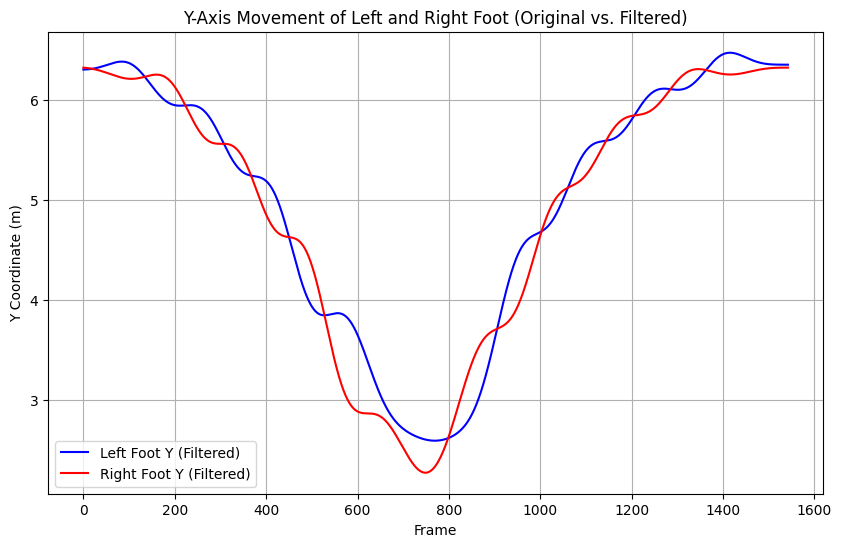

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_c.xlsx"
df = pd.read_excel(file_path)

# Extract Y-axis data for left and right foot
lfoot_y = df['LFoot_X_m']
rfoot_y = df['RFoot_X_m']

# Define Butterworth low-pass filter parameters
cutoff = 0.2  # Cutoff frequency in Hz
order = 4   # Filter order
fs = 30     # Sampling rate in Hz (assuming 30 fps from file name)

# Design Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter to data
def apply_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Filter the knee data
lfoot_y_filtered = apply_lowpass_filter(lfoot_y, cutoff, fs, order)
rfoot_y_filtered = apply_lowpass_filter(rfoot_y, cutoff, fs, order)

# Create a line plot
plt.figure(figsize=(10, 6))
#plt.plot(lfoot_y, label='Left Foot Y (Original)', color='blue', alpha=0.5, linestyle='--')
plt.plot(lfoot_y_filtered, label='Left Foot Y (Filtered)', color='blue')
#plt.plot(rfoot_y, label='Right Foot Y (Original)', color='red', alpha=0.5, linestyle='--')
plt.plot(rfoot_y_filtered, label='Right Foot Y (Filtered)', color='red')
plt.xlabel('Frame')
plt.ylabel('Y Coordinate (m)')
plt.title('Y-Axis Movement of Left and Right Foot (Original vs. Filtered)')
plt.legend()
plt.grid(True)
plt.show()

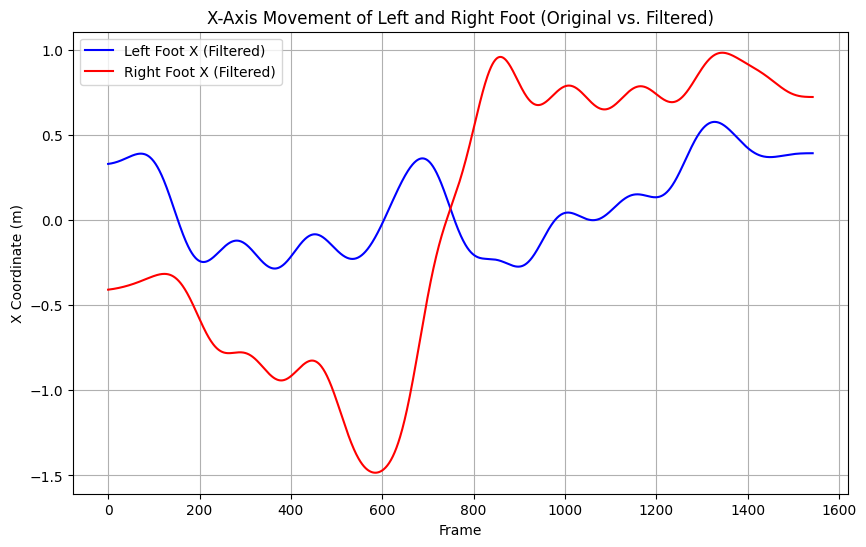

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_c.xlsx"
df = pd.read_excel(file_path)

# Extract Y-axis data for left and right foot
lfoot_y = df['LFoot_X_m']
rfoot_y = df['RFoot_X_m']

# Define Butterworth low-pass filter parameters
cutoff = 0.2  # Cutoff frequency in Hz
order = 4   # Filter order
fs = 30     # Sampling rate in Hz (assuming 30 fps from file name)

# Design Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter to data
def apply_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Filter the knee data
lfoot_y_filtered = apply_lowpass_filter(lfoot_y, cutoff, fs, order)
rfoot_y_filtered = apply_lowpass_filter(rfoot_y, cutoff, fs, order)

# Create a line plot
plt.figure(figsize=(10, 6))
#plt.plot(lfoot_y, label='Left Foot Y (Original)', color='blue', alpha=0.5, linestyle='--')
plt.plot(lfoot_y_filtered, label='Left Foot X (Filtered)', color='blue')
#plt.plot(rfoot_y, label='Right Foot Y (Original)', color='red', alpha=0.5, linestyle='--')
plt.plot(rfoot_y_filtered, label='Right Foot X (Filtered)', color='red')
plt.xlabel('Frame')
plt.ylabel('X Coordinate (m)')
plt.title('X-Axis Movement of Left and Right Foot (Original vs. Filtered)')
plt.legend()
plt.grid(True)
plt.show()

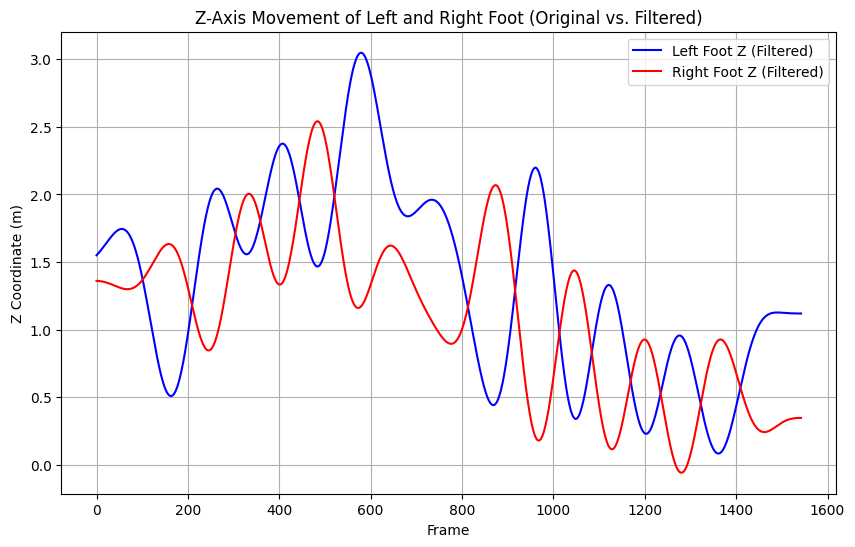

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\converted_3d_keypoints_c.xlsx"
df = pd.read_excel(file_path)

# Extract Y-axis data for left and right foot
lfoot_y = df['LFoot_Z_m']
rfoot_y = df['RFoot_Z_m']

# Define Butterworth low-pass filter parameters
cutoff = 0.2  # Cutoff frequency in Hz
order = 4   # Filter order
fs = 30     # Sampling rate in Hz (assuming 30 fps from file name)

# Design Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply filter to data
def apply_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Filter the knee data
lfoot_y_filtered = apply_lowpass_filter(lfoot_y, cutoff, fs, order)
rfoot_y_filtered = apply_lowpass_filter(rfoot_y, cutoff, fs, order)

# Create a line plot
plt.figure(figsize=(10, 6))
#plt.plot(lfoot_y, label='Left Foot Y (Original)', color='blue', alpha=0.5, linestyle='--')
plt.plot(lfoot_y_filtered, label='Left Foot Z (Filtered)', color='blue')
#plt.plot(rfoot_y, label='Right Foot Y (Original)', color='red', alpha=0.5, linestyle='--')
plt.plot(rfoot_y_filtered, label='Right Foot Z (Filtered)', color='red')
plt.xlabel('Frame')
plt.ylabel('Z Coordinate (m)')
plt.title('Z-Axis Movement of Left and Right Foot (Original vs. Filtered)')
plt.legend()
plt.grid(True)
plt.show()

3d Normalised to meters to kinect body joints

In [21]:
import pandas as pd
import numpy as np
import os

# Define input file and output folder
input_file = "C:/Users/akhileshsing2024/AlphaPose/results/converted_3d_keypoints_c.xlsx"
output_folder = "C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/kinect_body_joints"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate output file path with same name as input but with .csv extension
output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(input_file))[0]+"_kinect.csv")

# Load the Excel file
df = pd.read_excel(input_file)

# Recording frame rate
frame_rate = 30

# Calculate timestamps
num_frames = len(df)
timestamps = np.linspace(0, num_frames / frame_rate, num_frames)

# Define joint names and map with Azure Kinect indices
joint_mapping = {
    "Hip": 0,        # Pelvis
    "RHip": 22,      # Hip Right
    "RKnee": 23,     # Knee Right
    "RFoot": 25,     # Foot Right
    "LHip": 18,      # Hip Left
    "LKnee": 19,     # Knee Left
    "LFoot": 21,     # Foot Left
    "Spine": 1,      # Spine Naval
    "Thorax": 2,     # Spine Chest
    "Neck": 3,       # Neck
    "Head": 26,      # Head
    "LShoulder": 5,  # Shoulder Left
    "LElbow": 6,     # Elbow Left
    "LWrist": 7,     # Wrist Left
    "RShoulder": 12, # Shoulder Right
    "RElbow": 13,    # Elbow Right
    "RWrist": 14     # Wrist Right
}

# Prepare output DataFrame
output_data = []

# Iterate through each frame
for frame_idx, row in df.iterrows():
    timestamp = timestamps[frame_idx]
    # Assume PersonID is in the DataFrame or default to 0 if not present
    person_id = row.get('PersonID', 0)
    
    # Iterate through each joint
    for joint, azure_idx in joint_mapping.items():
        pos_x = row[f'{joint}_X_m']
        pos_y = row[f'{joint}_Y_m']
        pos_z = row[f'{joint}_Z_m']
        
        output_data.append({
            'Timestamp': timestamp,
            'BodyID': person_id,
            'Joint_': azure_idx,
            'Position_x_': pos_x,
            'Position_y_': pos_y,
            'Position_z_': pos_z
        })

# Create output DataFrame
output_df = pd.DataFrame(output_data)

# Save to CSV in the output folder
output_df.to_csv(output_file, index=False)

print(f"Converted data saved to {output_file}")

Converted data saved to C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/kinect_body_joints\converted_3d_keypoints_c_kinect.csv


In [24]:
import pandas as pd
import numpy as np
import os

# Define input file and output folder
input_file = "C:/Users/akhileshsing2024/AlphaPose/results/converted_3d_keypoints_c.xlsx"
output_folder = "C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/kinect_body_joints"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate output file path with same name as input but with .csv extension
output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(input_file))[0]+"_kinect.csv")

# Load the Excel file
df = pd.read_excel(input_file)

# Recording frame rate
frame_rate = 30

# Calculate timestamps
num_frames = len(df)
timestamps = np.linspace(0, num_frames / frame_rate, num_frames)

# Define joint names and map with Azure Kinect indices
joint_mapping = {
    "Hip": 0,        # Pelvis
    "RHip": 22,      # Hip Right
    "RKnee": 23,     # Knee Right
    "RFoot": 25,     # Foot Right
    "LHip": 18,      # Hip Left
    "LKnee": 19,     # Knee Left
    "LFoot": 21,     # Foot Left
    "Spine": 1,      # Spine Naval
    "Thorax": 2,     # Spine Chest
    "Neck": 3,       # Neck
    "Head": 26,      # Head
    "LShoulder": 5,  # Shoulder Left
    "LElbow": 6,     # Elbow Left
    "LWrist": 7,     # Wrist Left
    "RShoulder": 12, # Shoulder Right
    "RElbow": 13,    # Elbow Right
    "RWrist": 14     # Wrist Right
}

# Prepare output DataFrame
output_data = []

# Iterate through each frame
for frame_idx, row in df.iterrows():
    timestamp = timestamps[frame_idx]
    # Assume PersonID is in the DataFrame or default to 0 if not present
    person_id = row.get('PersonID', 0)
    
    # Iterate through each joint
    for joint, azure_idx in joint_mapping.items():
        # Convert positions from meters to millimeters
        pos_x = row[f'{joint}_X_m'] * 1000  # Convert to mm
        pos_y = row[f'{joint}_Y_m'] * 1000  # Convert to mm
        pos_z = row[f'{joint}_Z_m'] * 1000  # Convert to mm
        
        output_data.append({
            'Timestamp': timestamp,
            'BodyID': person_id,
            'Joint_': azure_idx,
            'Position_x_': pos_x,
            'Position_y_': pos_y,
            'Position_z_': pos_z
        })

# Create output DataFrame
output_df = pd.DataFrame(output_data)

# Save to CSV in the output folder
output_df.to_csv(output_file, index=False)

print(f"Converted data (in millimeters) saved to {output_file}")

Converted data (in millimeters) saved to C:/Users/akhileshsing2024/AlphaPose/formatted_csv_files/kinect_body_joints\converted_3d_keypoints_c_kinect.csv


In [ ]:
import pandas as pd

# Load the Excel file (replace 'your_file.xlsx' with the actual file path)
input_file = r"C:\Users\akhileshsing2024\AlphaPose\results\iphone-13 30fps\Alphose-result.xlsx"
df = pd.read_excel(input_file)

# Calculate pelvis coordinates for each row
df['pelvis_x'] = (df['keypoint_12_x'] + df['keypoint_13_x']) / 2
df['pelvis_y'] = (df['keypoint_12_y'] + df['keypoint_13_y']) / 2
df['pelvis_confidence'] = (df['keypoint_12_confidence'] + df['keypoint_13_confidence']) / 2

# Extract pelvis_y for initial (first row) and final (last row) points
pelvis_1 = df['pelvis_y'].iloc[0]  # Initial pelvis y-coordinate
pelvis_2 = df['pelvis_y'].iloc[-1]  # Final pelvis y-coordinate

# Calculate z2 using the formula: z2 = (z1 * pelvis_1) / pelvis_2
z1 = 21  # Depth at initial point in feet
z2 = (z1 * pelvis_1) / pelvis_2 if pelvis_2 != 0 else float('inf')  # Avoid division by zero

# Add z2 to the DataFrame (as a single value for the last row or as a new column)
df['z2_depth_feet'] = None  # Initialize column with None
df.loc[df.index[-1], 'z2_depth_feet'] = z2  # Set z2 for the last row

# Save the updated DataFrame to a new Excel file
output_file = r'C:\Users\akhileshsing2024\AlphaPose\results\iphone-13 30fps\output_with_pelvis.xlsx'
df.to_excel(output_file, index=False)

print(f"Pelvis and depth calculations completed. z2 = {z2:.4f} feet. Results saved to {output_file}")

Pelvis and depth calculations completed. z2 = 20.9901 feet. Results saved to C:\Users\akhileshsing2024\AlphaPose\results\iphone-13 30fps\output_with_pelvis.xlsx


In [179]:
import numpy as np
import pandas as pd

# Define image dimensions
image_width = 1080  # As provided
image_height = 1920  # As provided

# Load the 3D coordinates from the .npy file
X3d = np.load(r"C:\Users\akhileshsing2024\AlphaPose\results\X3D.npy")

# Verify the shape
print("X3d shape:", X3d.shape)  # Should be (331, 17, 3)

# Reshape the array to (331 * 17, 3) for processing
num_frames, num_keypoints, num_coords = X3d.shape
pixel_coords = X3d.reshape(-1, num_coords).copy()  # Shape: (331 * 17, 3)

# Convert normalized x_n, y_n to pixel coordinates
pixel_coords[:, 0] = pixel_coords[:, 0] * image_width  # x_pixel = x_n * width
pixel_coords[:, 1] = pixel_coords[:, 1] * image_height  # y_pixel = y_n * height
# z_n is left unchanged

# Create frame and keypoint indices for the DataFrame
frame_indices = np.repeat(np.arange(num_frames), num_keypoints)  # Repeat frame index for each keypoint
keypoint_indices = np.tile(np.arange(num_keypoints), num_frames)  # Repeat keypoint indices for each frame

# Create a DataFrame with frame, keypoint, and converted coordinates
df = pd.DataFrame({
    'frame': frame_indices,
    'keypoint': keypoint_indices,
    'x_pixel': pixel_coords[:, 0],
    'y_pixel': pixel_coords[:, 1],
    'z': pixel_coords[:, 2]
})

# Save the DataFrame to an Excel file
df.to_excel('X3d_pixel_coords.xlsx', index=False)

# Print the first few rows to verify
print("First 5 converted coordinates (frame, keypoint, x_pixel, y_pixel, z):")
print(df.head())

X3d shape: (331, 17, 3)
First 5 converted coordinates (frame, keypoint, x_pixel, y_pixel, z):
   frame  keypoint     x_pixel     y_pixel         z
0      0         0 -126.473282 -674.036865  0.000000
1      0         1 -183.047607 -676.919983  0.008458
2      0         2 -168.458405 -355.093018  0.080896
3      0         3 -151.034744  -60.321693  0.172543
4      0         4  -70.059776 -676.186279 -0.002933


In [136]:
import json
import pandas as pd

# Path to your single AlphaPose JSON file
json_file = r"C:\Users\akhileshsing2024\AlphaPose\output\alphapose-results.json"

# Output Excel file path
output_excel = r"C:\Users\akhileshsing2024\AlphaPose\results\alphapose_120fps_excel.xlsx"

keypoint_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

data = []

with open(json_file, 'r') as f:
    json_data = json.load(f)

# json_data is a list of people dictionaries
people = json_data

for person_idx, person in enumerate(people):
    keypoints = person.get("keypoints", [])
    if not keypoints:
        continue

    for i in range(0, len(keypoints), 3):
        kp_id = i // 3
        x = keypoints[i]
        y = keypoints[i+1]
        confidence = keypoints[i+2]
        kp_name = keypoint_names[kp_id] if kp_id < len(keypoint_names) else f"Keypoint_{kp_id}"
        data.append({
            "Person": person_idx + 1,
            "Keypoint": kp_name,
            "X": x,
            "Y": y,
            "Confidence": confidence
        })

df = pd.DataFrame(data)
df.to_excel(output_excel, index=False, engine="openpyxl")

print(f"Excel file saved to: {output_excel}")

Excel file saved to: C:\Users\akhileshsing2024\AlphaPose\results\alphapose_120fps_excel.xlsx


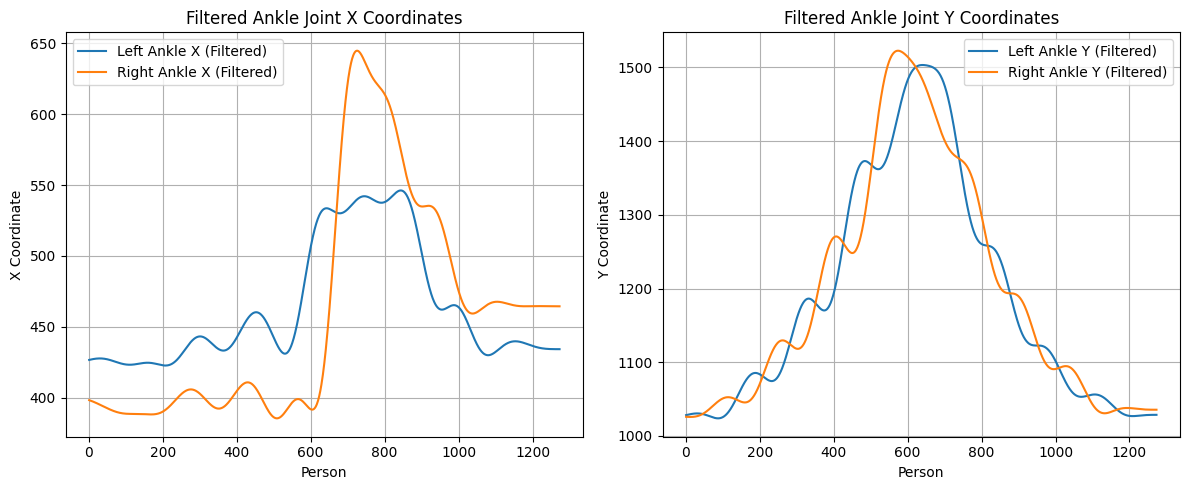

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the Excel file (update the path accordingly)
file_path = r"C:\Users\akhileshsing2024\AlphaPose\results\alphapose_120fps_excel.xlsx"
df = pd.read_excel(file_path)

# Filter data for the ankle joints only
ankle_df = df[df['Keypoint'].isin(['Left Ankle', 'Right Ankle'])]

# Pivot the data to have columns for Left Ankle X, Left Ankle Y, Right Ankle X, Right Ankle Y per frame/person
pivot_x = ankle_df.pivot(index='Frame', columns='Keypoint', values='X')
pivot_y = ankle_df.pivot(index='Frame', columns='Keypoint', values='Y')

# Butterworth low-pass filter design
def butter_lowpass_filter(data, cutoff=1, fs=120.0, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the filter to each ankle coordinate series
pivot_x_filtered = pivot_x.copy()
pivot_y_filtered = pivot_y.copy()

for col in pivot_x.columns:
    pivot_x_filtered[col] = butter_lowpass_filter(pivot_x[col].values)

for col in pivot_y.columns:
    pivot_y_filtered[col] = butter_lowpass_filter(pivot_y[col].values)

# Plotting the filtered data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(pivot_x_filtered.index, pivot_x_filtered['Left Ankle'], label='Left Ankle X (Filtered)')
plt.plot(pivot_x_filtered.index, pivot_x_filtered['Right Ankle'], label='Right Ankle X (Filtered)')
plt.xlabel('Person')  # Or 'Frame' if appropriate
plt.ylabel('X Coordinate')
plt.title('Filtered Ankle Joint X Coordinates')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(pivot_y_filtered.index, pivot_y_filtered['Left Ankle'], label='Left Ankle Y (Filtered)')
plt.plot(pivot_y_filtered.index, pivot_y_filtered['Right Ankle'], label='Right Ankle Y (Filtered)')
plt.xlabel('Person')  # Or 'Frame' if appropriate
plt.ylabel('Y Coordinate')
plt.title('Filtered Ankle Joint Y Coordinates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [186]:
import numpy as np
import pandas as pd

# Load the .npy file
npy_path = r"C:\Users\akhileshsing2024\AlphaPose\results\X3D.npy"
# npy_path = r"C:\Users\akhileshsing2024\AlphaPose\results\X3D_non_normalized.npy"
data = np.load(npy_path)  # Shape: [frames, 17, 3] for keypoints



frames, joints, dims = data.shape
columns = []

# Generate column names like Joint0_X, Joint0_Y, Joint0_C, ...
for j in range(joints):
    columns.extend([f"Joint{j}_X", f"Joint{j}_Y", f"Joint{j}_z"])

# Flatten each frame into a row
flattened_data = data.reshape(frames, joints * dims)

# Convert to DataFrame
df = pd.DataFrame(flattened_data, columns=columns)

# Save to Excel
excel_path = r"C:\Users\akhileshsing2024\AlphaPose\results\3d_output_keypoints.xlsx"
df.to_excel(excel_path, index=False)
print(f"Excel file saved to: {excel_path}")


Excel file saved to: C:\Users\akhileshsing2024\AlphaPose\results\3d_output_keypoints.xlsx
